<a href="https://colab.research.google.com/github/devorahst/Test/blob/main/DVariable.CODISNDISeligibleProfile/Section_1_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains the code that runs ANOVA on age vs CODIS eligiblity. It also makes the lineplot for age vs eligiblity used in the manuscript.

#Set-Up
This block will load in the dataset and filter it (remove all site 6 data and cases with a non-female victim)

In [ ]:
#pulls up our SAK dataset
#@title Upload Dataset
file_id = "13DLmmbYXonl9alHR4VobfeTuA_IxlQxZ" #@param {type:"string"}
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!pip install -U scikit-learn

from scipy.stats import chi2_contingency
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

with open(fileId['title'], encoding="utf8", errors='ignore') as f:
  df = pd.read_csv(f)

df = df.apply(pd.to_numeric, errors='ignore')
predictedVariable = "CODISNDISeligibleProfile"


#delete rows that don't have a value for CODISNDISeligibleProfile

predictedFeatures = ['CODISNDISeligibleProfile', 'SDISeligibleprofile']  

numericalFeatures = ['Age', 'Timebetweenassaultandexaminhours', 'PainLevel', 'MulitipleSuspectNumber', 
                     'NumberofUnknownresponses', 'NumberAssaultiveActs', 'Numberofphysicalinjuries', 'Numberofgentialinjuries',
                     'NumberOFitemsTested', 'TimeBetweenCollectAndDNAext', 'TimeBetweenSubmissionANDtesting', 'NumberOfswabsQuantMaleDNA',
                     'NumberOfswabsDNAanalysis', 'NumberofSTRDNAloci', 'NumberOFswabsSTRDNAprofile', 'NumberOfYSTRDNAloci']

categoricalFeatures = ['Site', 'EXAMbySANE', 'YearKitCollected', 'KITbroughtTOcrimelab', 'KITlengthofSubmissionTime',
                       'UnderAge18', 'Gender', 'ExamDeclined', 'Noninterview', 'Race', 'PriorHxofSAover14',
                       'PriorHxofSAunder14', 'Student', 'Military', 'Pain', 'PainLocation1','PainLocation2', 
                       'PainLocation3', 'PainLocation4','PainTreatment', 'PermanentAddress', 'CurrentPhysicalmedprob',
                       'MedProbChronic', 'MedProbInfection', 'MedProbBlood', 'MedProbCardiac', 'MedProbEar', 'MedProbEndocrine',
                       'MedProbEye', 'MedProbGI', 'MedProbGU', 'MedProbGYN', 'MedProbImmune', 'MedProbMusculoskeletal', 'MedProbNeurological',
                       'MedProbOral', 'MedProbRenal', 'MedProbRespiratory', 'MedProbSkin', 'MedProbOther', 'Medication',
                       'PsychotropicMEDuse', 'PsychotropicANTIPSYCHOTICSatypical', 'PsychotropicSTIMULANTuse', 'PsychotropicANTIANXIETY', 
                       'PsychotropicANTIDEPRESSANTS', 'PsychotropicANTISEIZUREbipolar', 'PsychotropicADDICTIONmeds','PsychotropicSLEEPaid', 'PsychotropicOTHER', 
                       'PsychotropicANTIPSYCHOTICStypical', 'PolypharmacyPsychMeds', 'ImmunizationstatusTETANUS', 'ReceivedTetanus',
                       'ImmunizationstatusHEP', 'ReceivedHepB', 'Sexualcontactwithin120hours', 'Selfdisclosurementalillness', 'MIdepression',
                       'MIanxiety', 'MIPTSD', 'MIpsychoticDisorders', 'MIadhd', 'MIpersonalitydisorder', 'MIbipolar', 'MIeatingdisorder', 'MIdrugalcoholdisorders', 
                       'MIother', 'SelfDiscolsureMentalillnessORuseofpsychotropics', 'OnlineMeetingOFsuspect', 'Suspectrelationship',
                       'Locationofassault', 'PatientActionScratch', 'PatientActionBite', 'PatientActionHit', 'PatientActionKick', 'PatientActionOther',
                       'Suspectrace', 'SuspectactionVERBAL', 'SuspectactionsGRABBEDHELD', 'SuspectactionsPHYSICALBLOWS', 'SuspectactionsSTRANGLEDCHOKED',
                       'SuspectactionsWEAPON', 'SuspectactionsRESTRAINTS', 'SuspectactionsBURNED', 'MultipleSuspects', 'SuspectedDrugfacilitated',
                       'Patientdruguse', 'PatientETOHuse', 'Suspectdruguse', 'SuspectETOHuse', 'PatientSuspectETOHordrug', 'LossOFconsciousnessORawareness',
                       'OneORmoreunknownanswer', 'Unknownanswerto4ormorequestions', 'UnknownanswertoALL', 'AsleepANDawakenedtoassault', 'MemoryLoss',
                       'LossOfconsciousness', 'DecreasedAwareness', 'TonicImmobility', 'Detachment', 'NOSApatientsVAGINApenis', 'NOSApatientsVAGINAfingerhand',
                       'NOSApatientsVAGINAmouth', 'NOSApatientsVAGINAobject', 'NOSApatientsANUSpenis', 'NOSApatientsANUSfingerhand', 'NOSApatientsANUSmouth', 
                       'NOSApatientsANUSobject', 'NOSApatientsPENISgenitals', 'NOSApatientsPENISfinger', 'NOSApatientsPENISmouth', 'NOSApatientsPENISobject', 
                       'NOSApatientsMOUTHpenis', 'NOSApatientsMOUTHfinger', 'NOSApatientsMOUTHmouth', 'NOSApatientsMOUTHobject', 'SUSPECTmouthcontactGENITALS', 
                       'SUSPECTmouthcontactMOUTH', 'SUSPECTmouthcontactOTHER', 'HANDSofSuspectBreast', 'HANDSofSuspectExtremities', 
                       'HANDSofSuspectOther', 'Ejaculation', 'CONDOMuse', 'LUBRICATIONuse', 'SuspectWASHEDpatient', 'SuspectINJUREDbypatient', 'PostassaultURINATED', 
                       'PostassaultDEFECATED', 'PostassaultDOUCHED', 'PostassaultVOMITED', 'PostassaultGARGLED', 'PostassaultBRUSHEDTEETH', 'PostassaultATEdrank', 
                       'PostassaultBATHED', 'PostassaultGENITALWIPE', 'PostassaultCHANGEDCLOTHING', 'PostassaultREMOVEDInserted', 'PhysicalORmentalimpairment', 'Physicalinjury', 
                       'LPIhead', 'LPIneck', 'LPIbreasts', 'LPIchestback', 'LPIabdomen', 'LPIextremities', 'TPIlaceration', 'TPIecchymosis', 'TPIabrasion', 'TPIredness', 
                       'TPIswelling', 'TPIbruise', 'TPIpetechiae', 'TPIincision', 'TPIavulsion', 'TPIdiscoloredmark', 'TPIpuncturewound', 'TPIfracture', 
                       'TPIbitemark', 'TPIburn', 'TPImissingorbrokenTEETH', 'TPIconjunctivalhemorrhage', 'Genitalinjury', 'LGIinnerthighs', 'LGIclitoralhoodclitoris', 
                       'LGIlabiamajora', 'LGIlabiaminora', 'LGIperiurethraltissueURETHRA', 'LGIperihymenaltissue', 'LGIhymen', 'LGIvagina', 'LGIcervix', 'LGIfossanavicularis', 
                       'LGIposteriorfourchette', 'LGIperineum', 'LGIperineum', 'LGIanalrectal', 'LGIbuttocks', 'LGImalePerianalperineum', 'LGIglanspenis', 'LGIpenileshaft', 
                       'LGImaleURETHRALmeatus', 'LGIscrotum', 'LGItestes', 'LGImaleanus', 'LGImalerectum', 'TGIlaceration', 'TGIecchymosis', 'TGIabrasion', 'TGIredness', 
                       'TGIswelling', 'TGIbruise', 'TGIpetechiae', 'TGIincision', 'TGIavulsion', 'TGIdiscoloredmark', 'TGIpuncturewound', 'ToludineDYEuptake', 'HIVnPEP', 
                       'UQuikcollected', 'Yscreen', 'NumberItemsWITH3cutoff', 'ItemsAnalyzed1', 'ItemsAnalyzed2', 'ItemsAnalyzed3', 'ItemsAnalyzed4', 'ItemsAnalyzed5', 
                       'ItemsAnalyzed6', 'ItemsAnalyzed7', 'ItemsAnalyzed8', 'ItemsAnalyzed9', 'ItemsAnalyzed10', 'TypesOFitemsTested', 'RandomSample20142015', 
                       'YearofDNAextraction', 'LocationOfTesting','DANYfundedSAK', 'DNAKitUsed', 'SerologyDoneBeforeDNA', 'QuantMaleDNAFound', 'QuantMaleSwabLoc1', 
                       'QuantMaleSwabLoc2', 'QuantMaleSwabLoc3', 'QuantMaleSwabLoc4', 'QuantMaleSwabLoc5', 'ProbableSTRDNAprofileOFsuspect', 'ProfileofSTRDNAloci', 'ProbableYSTRDNAprofile', 'ProfileOfYSTRDNAloci', 
                       'SwabLocationYSTRDNA', 'SecondSwabLocationYSTRDNA', 'SwabFromSuspectwithVictimDNA', 'ExcludeSuspect', 'ConsensualPartnerStandardSubmitted', 
                       'STRDNAProbableprofileTYPE', 'CODISprofileHit', 'STRDNAkitUsed', 'SUSPECTmouthcontactBREASTS', 'Swab1LocationSTRDNAprofile', 'Swab2LocationSTRDNAprofile',
                       'Swab3LocationSTRDNAprofile', 'SuspectStandardSubmitted', 'CODISNDISreasons', 'CODISSDISreasons']

#unusedFeatures and stringFeatures are columns that contain data that was relevant to medical professionals and for legal purposes, 
#but that aren't useful for our feature association or for predicting eligibility
unusedFeatures = ['filter_$', 'PainTreatmentYesNo', 'GenderMaleFemale', 'DVsuspect', 'RacePrimaryGroups', 'IPSAcombined', 'STRDNAcompleted', 
                  'PhysicalInjuryNOunknown', 'GenitalInjuryNOunknown']

stringFeatures = ['DeIdentifiedCase', 'Raceother', 'SchoolName', 'MilitaryBranchName', 'AddressIfnotPermanent', 'Currentmedprobtext',
                  'MedProbOtherText', 'Medicationtext', 'Sexualcontactwithin120hoursTYPE', 'SelfdisclosureMItype', 'OnlineMeetingName', 'SuspectrelationshipOTHER',
                  'LocationofassaultOTHER', 'Surfaceofassault', 'PatientActionOtherTEXT', 'SuspectraceOTHER', 'SuspectOTHERactions', 'NOSApatientsVAGINAobjectdescription',
                  'NOSApatientsANUSobjectdescription', 'NOSApatientsPENISobjectdescription', 'NOSApatientsMOUTHobjectdescription', 'EjaculationSITE', 'LUBRICATIONtype',
                  'SuspectINJUREDbypatientexplanation', 'Impairmentdescription', 'UBFSnumber', 'ISPnumber', 'DateSubmittedUBFS', 'DateofDNAextractionReport',
                  'BodySwabLocQuant', 'BodySwabDNAanalysis', 'BodySwabLocationSTRDNA', 'BodySwabYSTRDNA', 'ISPnotes2020', 'UBFSnotes2020', 'UBFSnotes2018', 'SUSPECTmouthcontactOTHERsite', 'UBFSnotes2014']

dummy1 = pd.get_dummies(df['Swab1ToDNAanalysis'])
dummy2 = pd.get_dummies(df['Swab2ToDNAanalysis'])
dummy3 = pd.get_dummies(df['Swab3ToDNAanalysis'])
dummy4 = pd.get_dummies(df['Swab4ToDNAanalysis'])

dummy4['0'] = dummy1['0']
dummy1['11'] = dummy2['11']
dummy3['0'] = dummy1['0']

newDummy = dummy1


newDummy = newDummy.where(newDummy != 0, dummy2)
newDummy = newDummy.where(newDummy != 0, dummy3)
newDummy = newDummy.where(newDummy != 0, dummy4)

# print(newDummy)
df['SwabToDNAanalysisNoquantmaleDNAfound'] = newDummy['0'].astype('category')
df['SwabToDNAanalysisVaginal'] = newDummy['1']
df['SwabToDNAanalysisCervical'] = newDummy['2']
df['SwabToDNAanalysisPerianal'] = newDummy['3']
df['SwabToDNAanalysisRectal'] = newDummy['4']
df['SwabToDNAanalysisOral'] = newDummy['5']
df['SwabToDNAanalysisBody'] = newDummy['6']
df['SwabToDNAanalysisUnderwear'] = newDummy['7']
df['SwabToDNAanalysisOtherClothing'] = newDummy['8']
df['SwabToDNAanalysisBedding'] = newDummy['9']
df['SwabToDNAanalysisCondom'] = newDummy['10']
df['SwabToDNAanalysisTampon'] = newDummy['11']

swabToDNAFeatures = ['SwabToDNAanalysisNoquantmaleDNAfound', 'SwabToDNAanalysisVaginal', 'SwabToDNAanalysisCervical', 'SwabToDNAanalysisPerianal', 'SwabToDNAanalysisRectal', 
                     'SwabToDNAanalysisOral','SwabToDNAanalysisBody', 'SwabToDNAanalysisUnderwear', 'SwabToDNAanalysisOtherClothing', 'SwabToDNAanalysisBedding', 
                     'SwabToDNAanalysisCondom','SwabToDNAanalysisTampon' ]

categoricalFeatures.extend(['SwabToDNAanalysisNoquantmaleDNAfound', 'SwabToDNAanalysisVaginal', 'SwabToDNAanalysisCervical', 'SwabToDNAanalysisPerianal', 'SwabToDNAanalysisRectal', 
                     'SwabToDNAanalysisOral','SwabToDNAanalysisBody', 'SwabToDNAanalysisUnderwear', 'SwabToDNAanalysisOtherClothing', 'SwabToDNAanalysisBedding', 
                     'SwabToDNAanalysisCondom','SwabToDNAanalysisTampon'])

df = df.replace(r'^\s+$', np.nan, regex=True)
df = df.replace({np.nan: "No Response"})
df = df.applymap(str)
df = df[df[predictedVariable] != "No Response"]

df = df[df['Site'] != '6'] #filtered dataframe without site 6 data
df = df[df['Gender'] == '1'] #dataframe containing information from only female respondents

MasterValentine_UpdatedCODIS_Feb12_2021.csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,9,301) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#Age

##Calculate p-value using ANOVA

In [ ]:
eligible = df[df['CODISNDISeligibleProfile'] != 'No Response']

selectedFeature = 'Age'

temp = pd.DataFrame()
temp[selectedFeature] = eligible[selectedFeature]
temp['CODISNDISeligibleProfile'] = eligible['CODISNDISeligibleProfile']
temp = temp[temp[selectedFeature] != "No Response"] 
eligible = temp[temp['CODISNDISeligibleProfile'] == "0"] 
ineligible = temp[temp['CODISNDISeligibleProfile'] == "1"] 

fvalue, pvalue = stats.f_oneway(eligible[selectedFeature], ineligible[selectedFeature]) #compares the means between eligible and noneligible within the given feature

print("P-value: " + str(pvalue))
print("F-Value: " + str(fvalue))

P-value: 1.1149917597613006e-09
F-Value: 37.2739118575957


##Lineplot
Code that arranges data into age group buckets and makes the lineplot comparing age of the victim and eligibility

In [ ]:
eligible = df[df['CODISNDISeligibleProfile'] != 'No Response']

currentVariable = 'Age'
age = eligible[eligible[currentVariable] != 'No Response']
age[currentVariable] = age[currentVariable].apply(pd.to_numeric, errors='coerce')
age['CODISNDISeligibleProfile'] = np.where((age['CODISNDISeligibleProfile'] == '0'), 'Not Eligible', age['CODISNDISeligibleProfile'])
age['CODISNDISeligibleProfile'] = np.where((age['CODISNDISeligibleProfile'] == '1'), 'Eligible', age['CODISNDISeligibleProfile'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [ ]:
#Split age groups into buckets
eligiblePerAgeGroup = {}
amountPerAgeGroup = []

ageHolder = 14
addAmount = 5
ageAddAmount = 6
while ageHolder <= age['Age'].max():

  currentGroup = age[(age[currentVariable] >= ageHolder) & (age[currentVariable] <= ageHolder + addAmount)]
  addAmount = 9
  eligiblePerAgeGroup[ageHolder] = ((len(currentGroup[currentGroup['CODISNDISeligibleProfile'] == 'Eligible']) / len(currentGroup)) * 100)
  amountPerAgeGroup.append(len(currentGroup))
  ageHolder += ageAddAmount
  ageAddAmount = 10

[36.975455265241486, 35.25835866261398, 35.10392609699769, 27.941176470588236, 21.935483870967744, 10.0, 5.263157894736842, 0.0, 0.0]


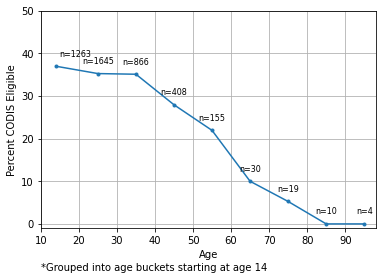

In [ ]:
ageGroup = list(eligiblePerAgeGroup.keys())         
numEligible = list(eligiblePerAgeGroup.values())
modifiedAgeGroup = list()
for a in ageGroup:
  if not a == 14:
    a += 5
  modifiedAgeGroup.append(a)
print(numEligible)

import matplotlib.pyplot as plt
import numpy as np


plt.plot(modifiedAgeGroup, numEligible, marker='.')
plt.xlabel("Age")
plt.ylabel("Percent CODIS Eligible");
i = 0
for x in eligiblePerAgeGroup:
    y = eligiblePerAgeGroup[x]

    label = "n=" + str(amountPerAgeGroup[i])
    i += 1
    plt.annotate(label, # this is the text
                 (x+5,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', 
                 fontsize = 8)

plt.grid()
plt.ylim([-1, 50])
plt.xlim([10, 98])

plt.text(10,-11,'*Grouped into age buckets starting at age 14')

plt.savefig('age_lineplot_without_annotation.pdf', dpi=600)
plt.show()
